In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/notebook_template.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-managed-notebook?download_url=https://raw.githubusercontent.com/hyunuk/vertex-ai-samples/experiment/notebooks/official/workbench/spark/spark_sample_notebook.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This notebook demonstrates how you ingest, analyze, and write back data to BigQuery using Apache Spark on Dataproc Serverless. Using the GitHub Activity Data, You will analyze repositories in GitHub and find out what kind of programming languages being used in their repositories.

### Dataset

The dataset you are using is the [GitHub Activity Data](https://console.cloud.google.com/marketplace/product/github/github-repos), available in [BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data). The first 1TB of data queried each month is free.

### Objective

This notebook demonstrates Apache Spark jobs that fetch data from BigQuery, analyze it, and write the results back to BigQuery. Through this process, you can learn a common use case in data engineering: ingesting data from a database, performing transformations during preprocessing, and writing back to another database. You also learn how to submit Apache Spark jobs in the Dataproc Serverless environment on Google Cloud Platform. 

In this project, these questions below will be answered.

- Which language is the most frequently used among the monoglot repos?
- What is the average size of each language among the monoglot repos?
- Given a language, which other languages are most frequently found in polyglot repos with it?

Note: repositories that encompass polyglot programming are referred to as polyglot repos and those which only contain one programming language are referred to as monoglot repos.


The steps performed include the following:

- Setting up the serverless environment.
- Configuring spark-bigquery-connector.
- Ingesting data from BigQuery to Spark DataFrame.
- Preprocessing ingested data.
- Analyze that the most frequently used programming language among the monoglot repos.
- Analyze that the average size of each language among the monoglot repos.
- Analyze that the most frequently used languages with a given language in polyglot repos.
- Write the result back to BigQuery
- Delete Dataproc Serverless Session
- Disable APIs being used in the project.

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage
* Dataproc Serverless

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), [Dataproc Serverless pricing](https://cloud.google.com/dataproc-serverless/pricing)
and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable Notebooks API, Vertex AI API, and Cloud Dataproc API](https://console.cloud.google.com/flows/enableapi?apiid=notebooks.googleapis.com,aiplatform.googleapis.com,dataproc&_ga=2.209429842.1903825585.1657549521-326108178.1655322249)

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Create a Dataproc cluster

**Note**: If you already have a cluster on Dataproc, you can skip this part and go to `Switch your kernel`.

The Spark job that you are going to execute this project is compute-intensive and could take a lot of time on a standard Notebook environment, so this tutorial uses a Dataproc cluster. To run your Spark jobs on a Dataproc cluster, you need to create a cluster with component gateway enabled and JupyterLab extension.

In [2]:
CLUSTER_NAME = "[your-cluster]"  # @param {type: "string"}
CLUSTER_REGION = "[your-region]"  # @param {type: "string"}

if CLUSTER_REGION == "[your-region]":
    CLUSTER_REGION = "us-central1"

print(f"CLUSTER_NAME: {CLUSTER_NAME}")
print(f"CLUSTER_REGION: {CLUSTER_REGION}")

CLUSTER_NAME: [your-cluster]
CLUSTER_REGION: us-central1


In [3]:
%%time
!gcloud dataproc clusters create $CLUSTER_NAME \
    --region=$CLUSTER_REGION \
    --enable-component-gateway \
    --optional-components=JUPYTER

ERROR: (gcloud.dataproc.clusters.create) PERMISSION_DENIED: Request had insufficient authentication scopes.
- '@type': type.googleapis.com/google.rpc.ErrorInfo
  domain: googleapis.com
  metadata:
    method: google.cloud.dataproc.v1.ClusterController.CreateCluster
    service: dataproc.googleapis.com
  reason: ACCESS_TOKEN_SCOPE_INSUFFICIENT

If you are in a compute engine VM, it is likely that the specified scopes during VM creation are not enough to run this command.
See https://cloud.google.com/compute/docs/access/service-accounts#accesscopesiam for more information about access scopes.
See https://cloud.google.com/compute/docs/access/create-enable-service-accounts-for-instances#changeserviceaccountandscopes for how to update access scopes of the VM.


**Note**: Your `CLUSTER_NAME` must be unique and must start with a lowercase letter followed by up to 51 lowercase letters, numbers, and hyphens, and cannot end with a hyphen.

#### Switch your kernel

**Note**: If you already select your kernel as Python 3 on your Dataproc cluster, you can skip this part.

In order to execute Apache Spark jobs on Dataproc Clusters, you need to change your kernel to Python 3 on your cluster name.

Click the button on top-right corner and select `Python 3 on CLUSTER_NAME: Dataproc cluster in REGION (Remote)`

If you switch your kernel here, you will lost all variables declared above, so you must execute following code after switching your kernel.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [4]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  dasi22


Otherwise, set your project ID here.

In [5]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type: "string"}

In [6]:
! gcloud config set project $PROJECT_ID -q

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  We recommend that you choose the region closest to you.

In [7]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [8]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

#### Create a Cloud Storage bucket

The Spark DataFrame created during this project will be stored in BigQuery. The data will be written first to the bucket in Google Cloud Storage(GCS) and then it is loaded it to BigQuery.
A GCS bucket must be configured to indicate the temporary data location.

Set the name of your Cloud Storage bucket below. It must be unique across all Cloud Storage buckets.

In [9]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = f"{PROJECT_ID}{TIMESTAMP}"
    BUCKET_URI = f"gs://{BUCKET_NAME}"

In [10]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://dasi2220220714011427/...


Validate access to your Cloud Storage bucket by displaying the bucket's metadata:

In [11]:
! gsutil ls -L -b $BUCKET_URI

gs://dasi2220220714011427/ :
	Storage class:			STANDARD
	Location type:			region
	Location constraint:		US-CENTRAL1
	Versioning enabled:		None
	Logging configuration:		None
	Website configuration:		None
	CORS configuration: 		None
	Lifecycle configuration:	None
	Requester Pays enabled:		None
	Labels:				None
	Default KMS key:		None
	Time created:			Thu, 14 Jul 2022 01:14:28 GMT
	Time updated:			Thu, 14 Jul 2022 01:14:28 GMT
	Metageneration:			1
	Bucket Policy Only enabled:	True
	Public access prevention:	inherited
	ACL:				[]
	Default ACL:			[]


#### Create a BigQuery resource

Using BUCKET_NAME created above, create a BigQuery resource.

In [12]:
! bq mk $BUCKET_NAME

Dataset 'dasi22:dasi2220220714011427' successfully created.


## Tutorial

### Import required libraries

In [13]:
# A Spark Session is how you interact with Spark SQL to create Dataframes
from pyspark.sql import SparkSession
# PySpark functions
from pyspark.sql.functions import UserDefinedFunction, col, size
# These allow us to create a schema for our data
from pyspark.sql.types import ArrayType, IntegerType, StringType

### Initialize the SparkSession and fetch data from BigQuery

In [14]:
spark = (
    SparkSession.builder.appName("spark-bigquery-polyglot-language-demo")
    .config(
        "spark.jars",
        "gs://spark-lib/bigquery/spark-bigquery-with-dependencies_2.12-0.25.2.jar",
    )
    .config("spark.sql.debug.maxToStringFields", "500")
    .getOrCreate()
)

# Load Github Activity Public Dataset from BigQuery.
df = (
    spark.read.format("bigquery")
    .option("table", "bigquery-public-data.github_repos.languages")
    .load()
)

df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/14 01:14:38 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/07/14 01:14:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/07/14 01:14:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/07/14 01:14:38 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)



### Preprocessing

Based on the schema printed above, data of the GitHub Activity is not stored in primitive types, but is instead stored in arrays. 

To work more effectively with the data, you need to preprocess it to primitive types and separate data for monoglot repos and polyglot repos. Once you create preprocessed columns, it makes our future tasks much faster.

In [15]:
# Define constants for further use.
LIMIT = 10
EXPLODE_PIE_CHART = tuple([0.05] * LIMIT)


def language_to_mono_language(language) -> str:
    """
    Preprocess function takes language and return it's name if language only has 1 elements.
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300]]
    Returns:
        Monorepo's name
    """
    if len(language) != 1:
        return None
    return language[0].name


def language_to_mono_size(language) -> int:
    """
    Preprocess function takes language and return it's bytes if language only has 1 elements.
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300]]
    Returns:
        Monorepo's bytes
    """
    if len(language) != 1:
        return 0
    return language[0].bytes


def language_to_poly_language(language) -> str:
    """
    Preprocess function takes language and return the top 3 language's name based on their bytes.
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300],
                                     [name: "Java", bytes: 200]]
    Returns:
        Polyrepo's name in string form separate by commas
    """
    if len(language) < 2:
        return None
    # Sort language by their bytes in a descending order.
    language.sort(key=lambda x: -x.bytes)
    top_3 = language[:3]

    # Sort top_3 language by their name.
    top_3.sort(key=lambda x: x.name)
    ret = []
    for elem in top_3:
        ret.append(elem.name)
    return ", ".join(ret)


# Copy over df to preprocessed_df
preprocessed_df = df.alias("preprocessed_df")

# Declare dictionary with keys column names and values User Defined Functions (UDF) and return types.
udf_map = {
    "mono_language": (language_to_mono_language, StringType()),
    "mono_size": (language_to_mono_size, IntegerType()),
    "poly_language": (language_to_poly_language, StringType()),
}

# Iterate through udf_map to preprocess columns using UDF.
for name, udf in udf_map.items():
    preprocessed_df = preprocessed_df.withColumn(
        name, UserDefinedFunction(*udf)(col("language"))
    )

# Drop the language column.
preprocessed_df = preprocessed_df.drop("language")
# Create a temporary view for using SparkSQL.
preprocessed_df.createOrReplaceTempView("df_view")
preprocessed_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- mono_language: string (nullable = true)
 |-- mono_size: integer (nullable = true)
 |-- poly_language: string (nullable = true)



After preprocessing, the language column is dropped and it is separated into three columns.

In [16]:
# See the number of repositories of monoglot(single language used) and polyglot(multiple languages used).
mono = preprocessed_df.where(size(col("language")) == 1).count()
print(f"The number of repositories that use only one language is {mono}")

poly = preprocessed_df.where(size(col("language")) > 1).count()
print(f"The number of repositories that use multiple language is {poly}")

The number of repositories that use only one language is 1203335


The number of repositories that use multiple language is 1752486


About 60% of repositories uses more than two languages.

### Analyze

#### Which language is the most frequently used among the monoglot repos?
To answer this question, you can execute simple query below with the preprocessed column, `mono_language`.

In [17]:
%%time
# Get the monoglot repositories and sort them based on the popularity of languages.
mono_ranking = spark.sql(
    """
    SELECT
        df_view.mono_language,
        count(df_view.mono_language) AS `count`
    FROM
        df_view
    GROUP BY
        df_view.mono_language
    ORDER BY
        `count` DESC
"""
)

mono_ranking.show()

+-------------+------+
|mono_language| count|
+-------------+------+
|   JavaScript|203852|
|       Python|191097|
|         Java|183309|
|         Ruby|106330|
|          PHP| 96086|
|           C#| 57749|
|        Shell| 56176|
|           Go| 42846|
|  Objective-C| 22484|
|          C++| 21984|
|         HTML| 20729|
|            C| 16377|
|      Haskell| 15985|
|      Clojure| 12225|
|        Swift| 10898|
|        Scala| 10756|
|          CSS| 10619|
|            R|  9043|
|         Perl|  8883|
|         Rust|  8314|
+-------------+------+
only showing top 20 rows

CPU times: user 10.7 ms, sys: 8.43 ms, total: 19.1 ms
Wall time: 42.6 s


Using this `mono_ranking`, you can also visualize it using the pie chart.

CPU times: user 410 ms, sys: 62.7 ms, total: 473 ms
Wall time: 40.5 s


<AxesSubplot:title={'center':'Monoglot repositories'}>

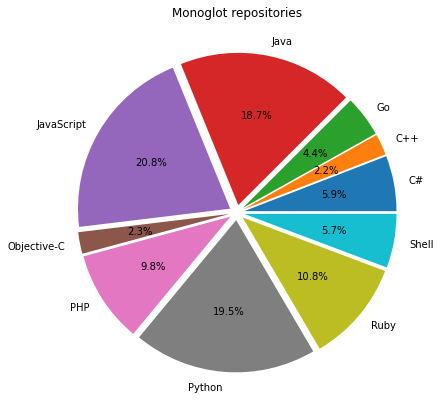

In [18]:
%%time
# Convert Spark DataFrame to Pandas DataFrame to display the pie chart.
mono_panda = mono_ranking.toPandas()[:LIMIT].copy()
mono_panda.groupby(["mono_language"]).sum().plot(
    kind="pie",
    y="count",
    autopct="%1.1f%%",
    label="",
    title="Monoglot repositories",
    legend=False,
    figsize=(7, 7),
    explode=EXPLODE_PIE_CHART,
)

#### What is the average size of each language among the monoglot repos?

You can use preprocessed columns, `mono_size` and `mono_language` to get the average size of each language.

the `mono_size` column's bytes are kilobytes. In the following query, `mono_size` is divided by 1000 to convert it to megabyte.

In [19]:
%%time
# Get the average size in megabyte of each monoglot repositories and sort by it's size
mono_ranking_avg_bytes = spark.sql(
    """
    SELECT
        df_view.mono_language, 
        round(avg(df_view.mono_size/1000)) AS `average_in_MB`,
        count(df_view.mono_language) AS `count`
    FROM 
        df_view
    GROUP BY
        df_view.mono_language
    ORDER BY
        `average_in_MB` DESC
"""
)

# Filter the result that the language has at least 500 repositories.
mono_ranking_avg_bytes = mono_ranking_avg_bytes.filter(col("count") > 500)
mono_ranking_avg_bytes.show()

+----------------+-------------+------+
|   mono_language|average_in_MB| count|
+----------------+-------------+------+
|Jupyter Notebook|       2224.0|  2539|
|          Pascal|        358.0|  1263|
|            HTML|        340.0| 20729|
|    ActionScript|        224.0|  1420|
|              C#|        224.0| 57749|
|    Visual Basic|        217.0|  2309|
|             Lua|        174.0|  7892|
|        Assembly|        165.0|   763|
|            Java|        152.0|183309|
|             TeX|        127.0|  3401|
|            Haxe|        103.0|   932|
|             PHP|         90.0| 96086|
|      Emacs Lisp|         89.0|  2708|
|          Matlab|         83.0|  4309|
|     Common Lisp|         80.0|  1999|
|               D|         77.0|   883|
|               R|         75.0|  9043|
|            Dart|         73.0|  1613|
|            Perl|         73.0|  8883|
|      PowerShell|         73.0|  4598|
+----------------+-------------+------+
only showing top 20 rows

CPU times: use

#### Given a language, which other languages are most frequently found in polyglot repos with it?

You already have a preprocessed column, `poly_language`. Using this column, you can implement a simple query to show the ranking of polyglot repositories with the top 3 languages, based on their size.

In [20]:
%%time
# Get the polyglot repositories by the popularity of languages.
poly_ranking = spark.sql(
    """
    SELECT
        df_view.poly_language,
        count(df_view.poly_language) AS count
    FROM
        df_view
    GROUP BY
        df_view.poly_language
    ORDER BY
        count DESC
"""
)

poly_ranking.show()

+--------------------+------+
|       poly_language| count|
+--------------------+------+
|CSS, HTML, JavaSc...|250751|
|CSS, JavaScript, PHP| 71307|
|     CSS, JavaScript| 60490|
|    HTML, JavaScript| 53499|
|       Python, Shell| 33754|
|           CSS, HTML| 26946|
|     CSS, HTML, Ruby| 25045|
|HTML, JavaScript,...| 22133|
|   Objective-C, Ruby| 21533|
|HTML, JavaScript,...| 19861|
|         Ruby, Shell| 19757|
|CSS, JavaScript, ...| 18015|
|CSS, JavaScript, ...| 16895|
|    Assembly, C, C++| 14933|
|              C, C++| 13912|
|      CSS, HTML, PHP| 13059|
|CSS, Java, JavaSc...| 13025|
|      C, C++, Python| 12877|
|   CSS, HTML, Python| 12718|
|         Java, Shell| 11965|
+--------------------+------+
only showing top 20 rows

CPU times: user 9.75 ms, sys: 7.26 ms, total: 17 ms
Wall time: 57.6 s


The majority of results were a mixture of HTML or CSS, so the result had many similar conbinations of HTML, CSS, and Javascript.

It may not be as interesting. What about the pie chart?

CPU times: user 254 ms, sys: 29.4 ms, total: 283 ms
Wall time: 58.1 s


<AxesSubplot:title={'center':'Polyglot repositories'}>

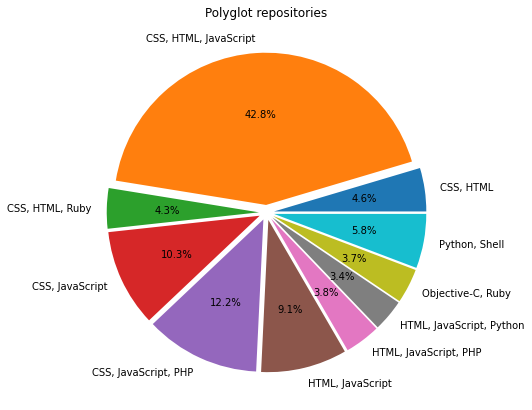

In [21]:
%%time
# Convert Spark DataFrame to Pandas DataFrame to display the pie chart.
poly_panda = poly_ranking.toPandas()[:LIMIT].copy()
poly_panda.groupby(["poly_language"]).sum().plot(
    kind="pie",
    y="count",
    autopct="%1.1f%%",
    label="",
    title="Polyglot repositories",
    legend=False,
    figsize=(7, 7),
    explode=EXPLODE_PIE_CHART,
)

When you visualize to a pie chart with the top 10 result, eight out of ten were contains either `HTML` or `CSS`.

Using the original data fetched from BigQuery, `df`, you can create combinations of languages in each repo.

In [22]:
# A Python package to get combinations.
from itertools import combinations
# A Python package to use type hint
from typing import List

# PySpark functions
from pyspark.sql.functions import explode

In [23]:
%%time
def reduce_language(language) -> List[str]:
    """
    Preprocess function takes language and reduce it to remove "bytes".
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300],
                                     [name: "Java", bytes: 200]]
    Returns:
        list of strings that contains name.
                  (e.g., reduced_languages = ["C", "Java"])
    """
    if len(language) < 2:
        return None
    reduced_languages = []
    for elem in language:
        # To write back to BigQuery, the name must be normalized. See normalize_name() function below.
        normalized_name = normalize_name(elem.name)
        reduced_languages.append(normalized_name)
    return reduced_languages


def preprocess_combination(language) -> List[List[str]]:
    """
    Preprocess function takes language and return every combination of language.
    Args:
        language: list of struct that contains name and bytes.
                  (e.g., language = [[name: "C", bytes: 300],
                                     [name: "Java", bytes: 200]]
    Returns:
        List of every possible combinations.
                  (e.g., arr_combinations = [["C", "Java"], ["Java", "C"]])
    """
    if not language:
        return None
    arr_combinations = []
    for combination in combinations(language, 2):
        arr_combinations.append(combination)
        arr_combinations.append(combination[::-1])
    return arr_combinations


def normalize_name(name: str) -> str:
    """
    Change the name of language since BigQuery has a set of invalid characters that cannot be used in their field.
    Args:
        name: string
    Returns:
        Normalized name: string
    """
    normalized_arr = []

    # The following set of characters cannot be used in BigQuery's field.
    invalid_chars = {",", ";", "{", "}", "(", ")", "\n", "\t", "="}

    # The name must start with a letter or underscore.
    if name[0].isnumeric():
        normalized_arr.append("_")

    for ch in name:
        # Skip if a character is in the set of invalid characters.
        if ch in invalid_chars:
            continue

        # Convert space or dot to underscore
        elif ch == " " or ch == ".":
            normalized_arr.append("_")

        # Lower the character to merge the same name (e.g., "Java" and "java")
        else:
            normalized_arr.append(ch.lower())

    # Convert the array to string
    return "".join(normalized_arr)


# Preprocess "reduced_languages" column using UDF.
df = df.withColumn(
    "reduced_languages",
    UserDefinedFunction(reduce_language, ArrayType(StringType()))(col("language")),
)

# Preprocess "combinations" column using UDF.
df = df.withColumn(
    "combinations",
    UserDefinedFunction(preprocess_combination, ArrayType(ArrayType(StringType())))(
        col("reduced_languages")
    ),
)

# Create another DataFrame from df that has repo_name and combinations as columns.
frequency_df = df.select(col("repo_name"), col("combinations")).where(
    size(col("language")) > 1
)
frequency_df.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- combinations: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)

CPU times: user 3.86 ms, sys: 14 ms, total: 17.9 ms
Wall time: 106 ms


Now frequency_df has repo and combinations of languages.

Next, you need to use explode function in Spark, which is similar with UNNEST function in SQL.

In [24]:
%%time
# Using explode(), the elements in combinations converted to rows.
frequency_df = frequency_df.withColumn("languages", explode(col("combinations")))

# Create columns for combinations of languages.
frequency_df = frequency_df.withColumn("language0", col("languages")[0])
frequency_df = frequency_df.withColumn("language1", col("languages")[1])

# crosstab() reshapes the current table into the frequency distribution table by using cross tabulations.
frequency_df = frequency_df.crosstab("language0", "language1")

# change the language0_language1 to languages.
frequency_df = frequency_df.withColumnRenamed("language0_language1", "languages")

CPU times: user 20.6 ms, sys: 12.4 ms, total: 33 ms
Wall time: 1min 46s


See [frequency distribution](https://en.wikipedia.org/wiki/Frequency_(statistics)) and [cross tabulations](https://en.wikipedia.org/wiki/Contingency_table).

Now you have a DataFrame that has frequency of each languages by a given language. Let's visualize it with some famous language.

In [25]:
%%time
# Set of famous languages. You can modify this set to show your favorite languages.
MAJOR_LANGUAGES = {"C", "C++", "Java", "Python", "JavaScript", "Go"}

# Declare a dictionary to store key as language name and value as the selected DataFrame
df_dict = dict()

for language in MAJOR_LANGUAGES:
    # Get a top ten languages of each language and store it to the dictionary.
    df_dict[language] = (
        frequency_df.select(col("languages"), language).sort(-col(language)).limit(10)
    )

CPU times: user 16.3 ms, sys: 14.3 ms, total: 30.6 ms
Wall time: 289 ms


CPU times: user 1.71 s, sys: 1.33 s, total: 3.03 s
Wall time: 16.4 s


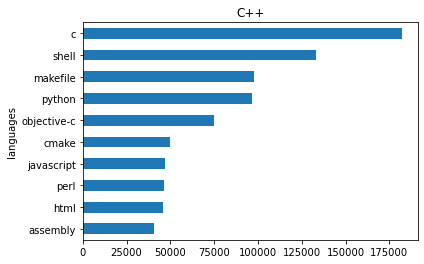

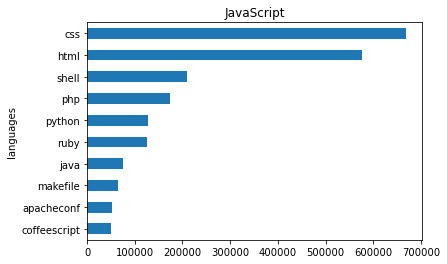

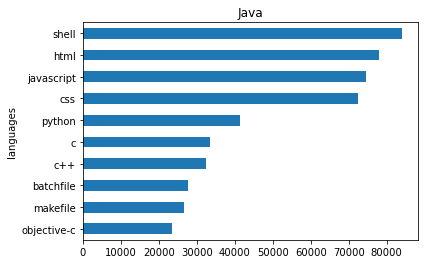

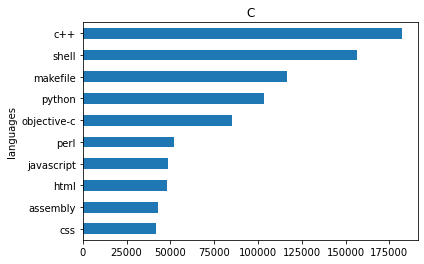

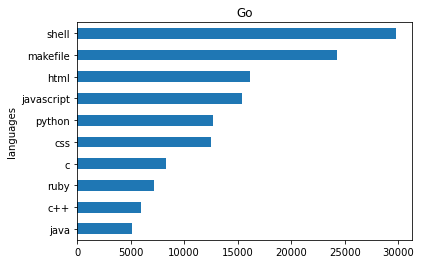

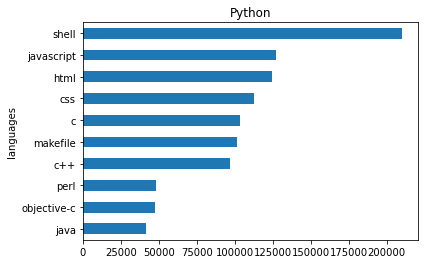

In [26]:
%%time
for language in df_dict:
    # Convert Spark DataFrame to Pandas DataFrame to display the bar chart.
    elem_panda = df_dict[language].toPandas()[:LIMIT].copy()
    elem_panda.set_index("languages", inplace=True)
    elem_panda.sort_values(language, ascending=True, inplace=True)
    elem_panda.plot(
        kind="barh",
        title=language,
        legend=False,
        label='',
    )

### Write back to the BigQuery

After analyzing these queries, we have several DataFrames. The ranking of monoglot repositories, the average bytes of monoglot repositories, and the frequency table of each language being used in a repository. 

In this project, these three DataFrames will be stored in BigQuery using the [spark-bigquery-connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector).

In [27]:
%%time
dataframes = {
    "mono_ranking": mono_ranking,
    "mono_ranking_avg_bytes": mono_ranking_avg_bytes,
    "frequency_table": frequency_df,
}

# Iterate through dataframes and save them to the BigQuery.
for df in dataframes:
    dataframes[df].write.format("bigquery").option(
        "temporaryGcsBucket", BUCKET_NAME
    ).option("table", f"{BUCKET_NAME}.{df}").save()

CPU times: user 44 ms, sys: 8.5 ms, total: 52.5 ms
Wall time: 1min 46s


If there is no error above, congratulations! your DataFrame is successfully stored in your BigQuery.

You can find the data via [this link](https://pantheon.corp.google.com/bigquery) or execute `bq` command-line tool like below.

In [28]:
QUERY = f"SELECT languages, python FROM {PROJECT_ID}.{BUCKET_NAME}.frequency_table ORDER BY python DESC LIMIT 10"

! bq query --nouse_legacy_sql $QUERY

+-------------+--------+
|  languages  | python |
+-------------+--------+
| shell       | 209842 |
| javascript  | 127040 |
| html        | 124631 |
| css         | 112778 |
| c           | 103242 |
| makefile    | 101581 |
| c++         |  96582 |
| perl        |  48474 |
| objective-c |  47495 |
| java        |  41362 |
+-------------+--------+


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

### Delete Vertex AI Workbench - Managed Notebook

To delete Vertex Ai Workbench - Managed Notebook used in this project, you can use this [Clean up](https://cloud.google.com/vertex-ai/docs/workbench/managed/create-managed-notebooks-instance-console-quickstart#clean-up) part of Managed notebooks page.

In [29]:
# Delete Google Cloud Storage bucket
! gsutil rm -r $BUCKET_URI

Removing gs://dasi2220220714011427/...


In [30]:
# Delete BigQuery dataset
! bq rm -r -f $BUCKET_NAME

In [ ]:
# Delete a Dataproc Cluster
! gcloud dataproc clusters delete $CLUSTER_NAME --region=$CLUSTER_REGION -q

After you delete the Dataproc Cluster, you can check your Datasets in BigQuery using the following command.

In [ ]:
! bq ls